### Домашнее задание №1 по курсу финансового моделирования

1. Реализовать на R генератор лучайных чисел с функцией распределения $F(x) = \frac{\chi_{[-1,2]}(x+1)(x+3)}{15}$
2. Построить график плотности распределения
3. Выборка из а) 10 б) 100 в) 1000 элементов
4. Гистограмма частот и плотность; сравнение
5. функция, которая считает по выборке минимум, максимум, разницу, среднее, выборочную дисперсию (с поправкой и без), среднеквадратическое отклонение, медиану, 0.25 и 0.75 квантиль, коэффициент вариации, коэффициент ассиметрии, коэффициент эксцесса

**В этой тетрадке я решу задание сразу на двух языках -- на питон и на R, а потом сравню впечатления**

In [1]:
%load_ext rpy2.ipython
import seaborn as sns
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%%time
# п. 1 на python
# зададим нашу функцию 
F = np.vectorize(lambda x: (x + 1)*(x + 3) / 15 * (-1 <= x <= 2))

# Плотность -- тупо производная
dF = np.vectorize(lambda x: 2*(x + 2) / 15 * (-1 <= x <= 2))

# обратная функция 
F_reversed = np.vectorize(lambda x: (math.sqrt(abs(15 * x + 1)) - 2) * (0 <= x <= 1))

# генератор случайных чисел 
def generate(N=10, F_reversed=F_reversed):
    x = np.random.random_sample(N)
    return F_reversed(x)

Wall time: 0 ns


In [3]:
%%time
%%R
# п. 1 на R
# исходная функция
F <- function(x) as.numeric(x >= - 1 &  x <= 2) * (x + 1) * (x + 3) / 15

# функция плотности распределения
dF <- function(x) as.numeric(2 >= x & x >= -1) * 2 * (x + 2) / 15
    
# функция, обратная к функции распределения
F_reversed <- function(x) ((15 * x + 1)**0.5 - 2) * as.numeric(0 <= x & x <= 1)   

# генератор случайных чисел    
generate <- function(size=10, F_r=F_reversed){
    unlist(lapply(runif(size, 0.0, 1.0), F_r))
}

Wall time: 212 ms


Wall time: 404 ms


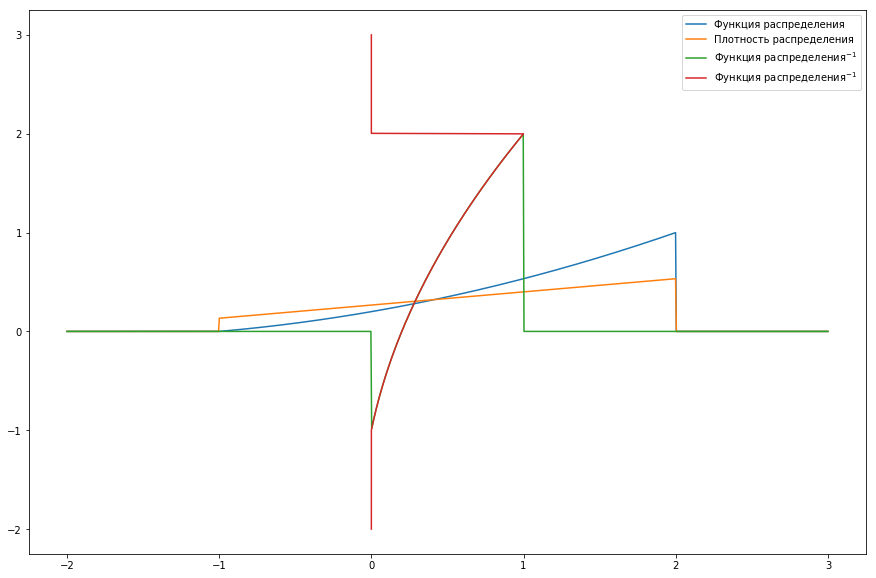

In [4]:
%%time
# п. 2 на python
plt.figure(figsize=(15, 10))
plt.plot(np.linspace(-2, 3, 1000), F(np.linspace(-2, 3, 1000)), label='Функция распределения');
plt.plot(np.linspace(-2, 3, 1000), dF(np.linspace(-2, 3, 1000)), label='Плотность распределения');
plt.plot(np.linspace(-2, 3, 1000), F_reversed(np.linspace(-2, 3, 1000)), label='Функция распределения$^{-1}$');
plt.plot(F(np.linspace(-2, 3, 1000)), np.linspace(-2, 3, 1000), label='Функция распределения$^{-1}$');
plt.legend();

Как видно &uarr;, графики с повернутыми осями (красный) и график обратной функции (зеленый) совпадают на интересующем нас промежутке. Значит, все хорошо и правильно. Построим еще отдельно график плотности и функцию распределения, что было видно нагляднее.

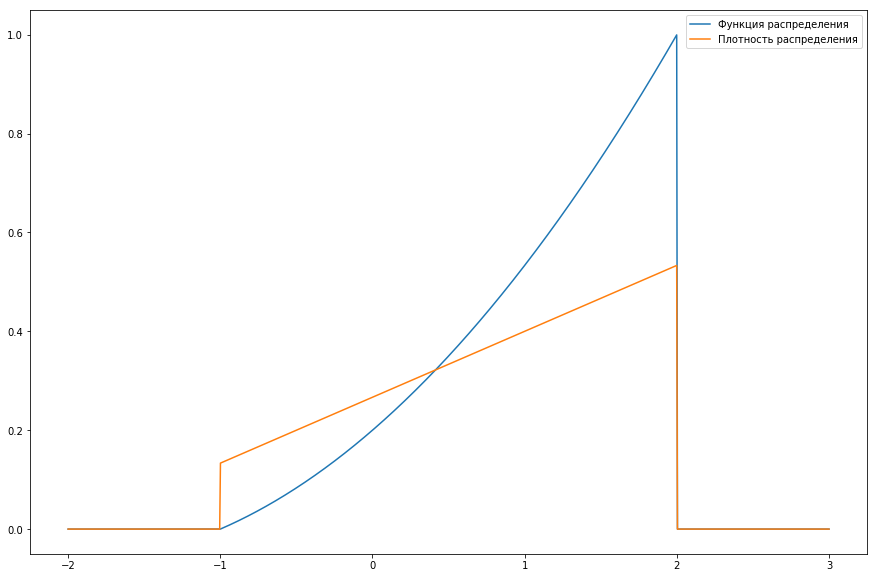

In [5]:
plt.figure(figsize=(15, 10))
plt.plot(np.linspace(-2, 3, 1000), F(np.linspace(-2, 3, 1000)), label='Функция распределения');
plt.plot(np.linspace(-2, 3, 1000), dF(np.linspace(-2, 3, 1000)), label='Плотность распределения');
plt.legend();

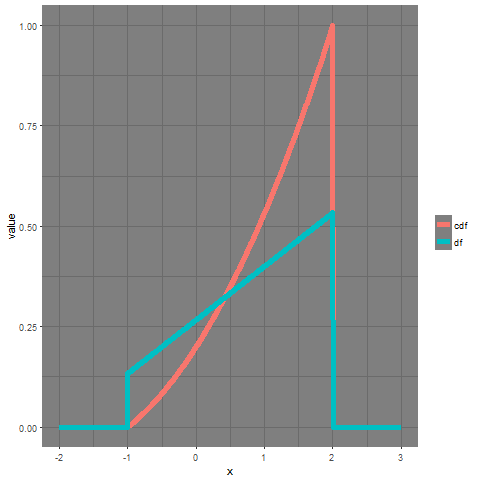

Wall time: 4.67 s


In [6]:
%%time
%%R 
# п. 2 на R    
df <- data.frame(x = 5*(1:1000)/1000 - 2)
df$cdf <- F(df$x)
df$df <- dF(df$x)

library(ggplot2)
library(data.table)
ggplot(data = melt(df, id.vars = 'x', measure.vars = c('cdf', 'df'))) +
    geom_line(aes(x, value, color=variable), size=2) + theme_dark() + labs(color='')

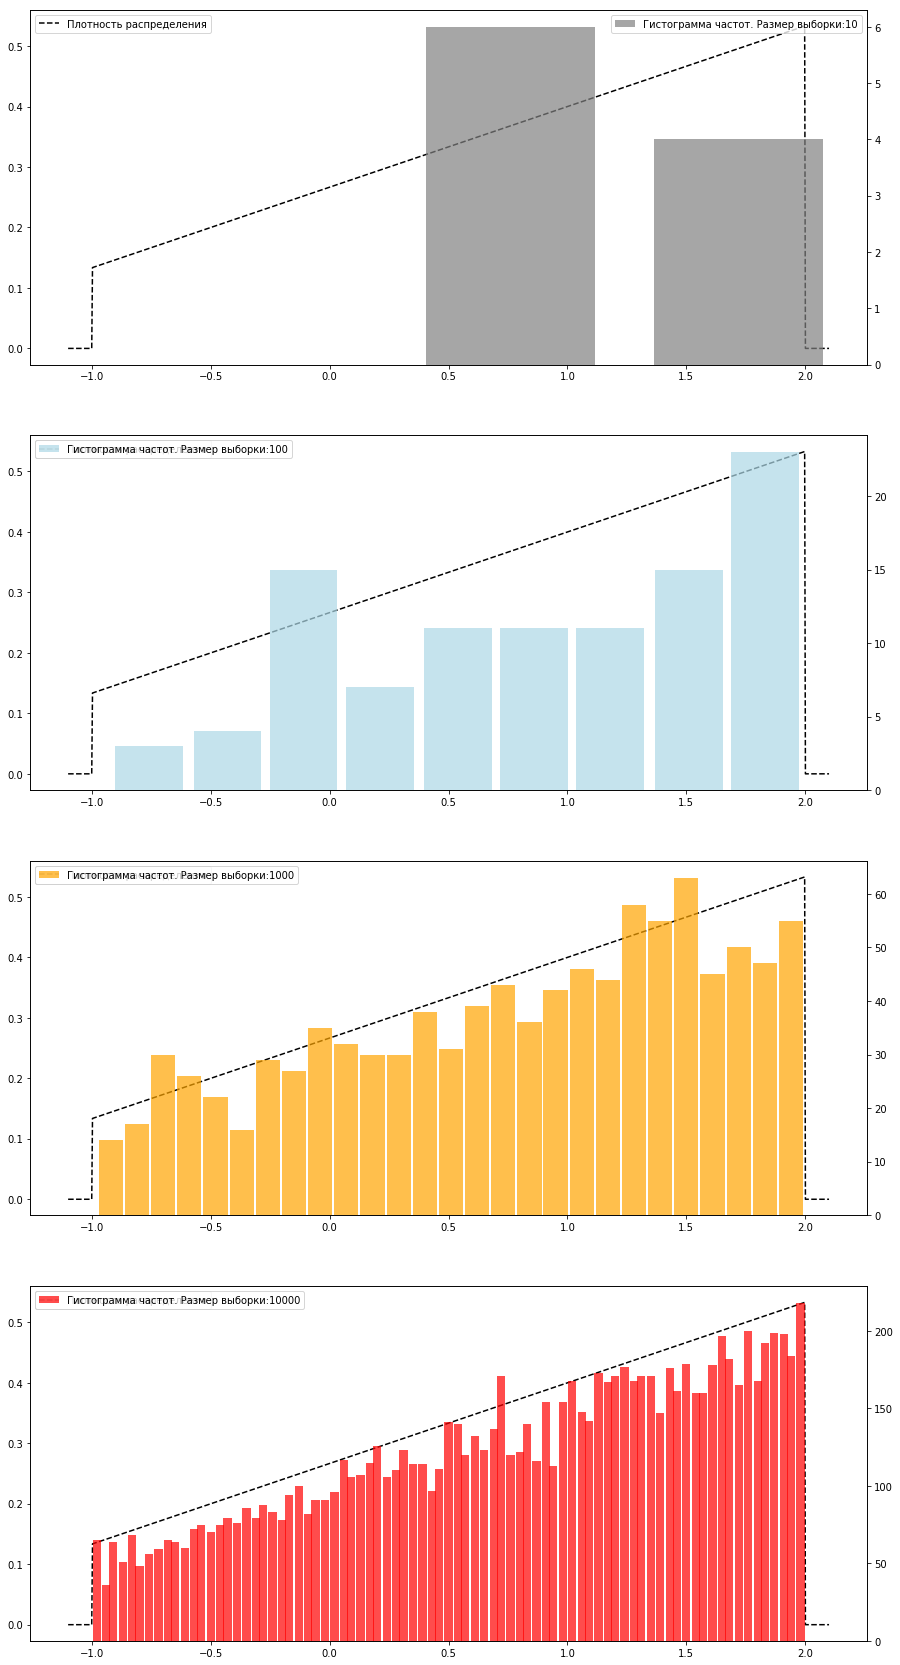

Wall time: 1.54 s


In [7]:
%%time
# пп. 3-4 на python
# Выборка из а) 10 б) 100 в) 1000  г) 10000 элементов  
v = list(map(generate, [10, 100, 1000, 10000]))
# метки и подсчеты
# 3**(x[0]+1)
counts, labels = np.array(list(map(lambda x: np.histogram(x[1], 3**(x[0]+1)), enumerate(v)))).T


# Гистограмма частот и плотность; сравнение
plt.figure(figsize=(15, 30))
for i,(l, c) in enumerate(zip(labels, counts)):
    
    ax = plt.subplot(4, 1, i + 1)
    ax.plot(np.linspace(-1.1, 2.1, 1000),
             dF(np.linspace(-1.1, 2.1, 1000)),
             label='Плотность распределения',
             color='black', ls='--')
    ax.legend()
    ax_ = ax.twinx()
    ax_.bar(x = [round((left + right) / 2, 2) for left, right in zip(l, l[1:])],
            height = c,
            width = 3 / len(l) * 0.95,
            alpha= 0.7,
            color=['gray','lightblue', 'orange', 'red'][i],
            label='Гистограмма частот. Размер выборки:' + str([10, 100, 1000, 10000][i]))
    ax_.legend()
plt.legend()    
plt.show();

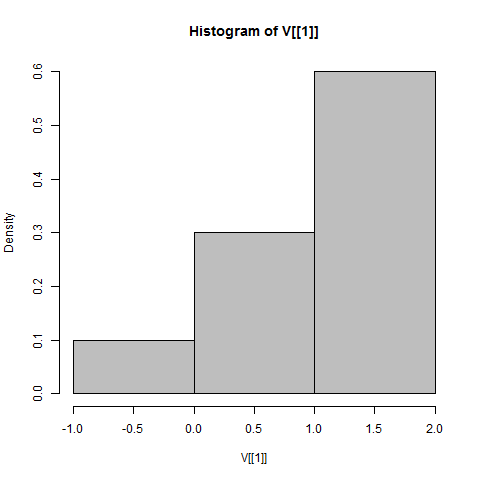

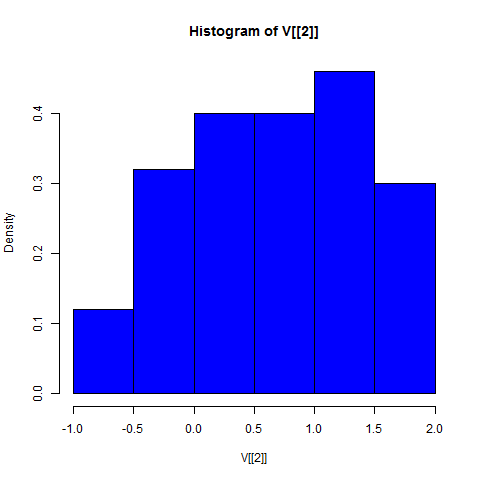

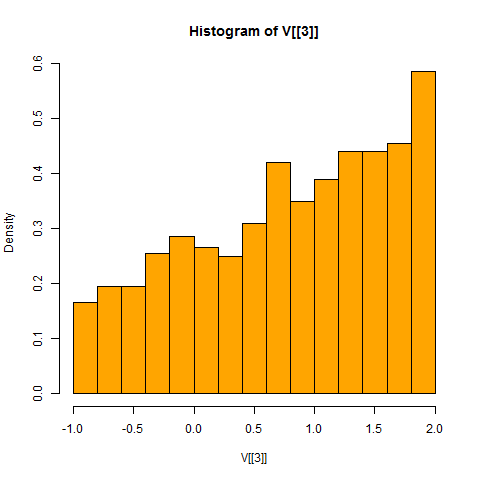

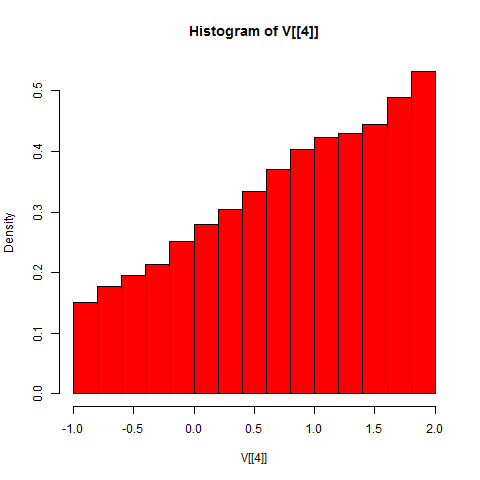

Wall time: 120 ms


In [18]:
%%time
%%R
# пп. 3-4 на R
V <- lapply(c(10, 100, 1000, 10000),generate)
hist(V[[1]], col='gray', freq=FALSE, breaks=3)
hist(V[[2]], col = 'blue', freq=FALSE, breaks=5)
hist(V[[3]], col = 'orange', freq=FALSE, breaks=15)
hist(V[[4]], col = 'red', freq=FALSE, breaks = 20)

In [9]:
%%time
# п.5 на python
from scipy.stats import variation, skew, kurtosis

def stats(x, name='значение'):
    values = [min(x),  # минимум
            max(x), # максимум
            max(x)-min(x), # разницу
            np.mean(x), #среднее
            np.var(x, ddof=1), np.var(x), # выборочную дисперсию (с поправкой и без)
            np.std(x), # среднеквадратическое отклонение
            np.median(x), # медиану
            np.percentile(x, 25),
            np.percentile(x, 0.75), # 0.25 и 0.75 квантиль
            variation(x), # коэффициент вариации 
            skew(x),      # коэффициент ассиметрии
            kurtosis(x)] #коэффициент эксцесса
    return pd.DataFrame(index = ['минимум', 'максимум', 'макс-мин', 'среднее', 'дисперсия с поправкой',
                        'дисперсия без поправки', 'среднеквадратичное отклонение', 'медиана',
                        '.25 квантиль', '.75 квантиль', 'коэффициент вариации',
                        'коэффициент ассиметрии', 'коэффицент эксцесса'], data = values, columns=[name])


result_python = pd.concat([stats(v[0], 'выборка из 10'), stats(v[1], 'выборка из 100'),
           stats(v[2], 'выборка из 1000'), stats(v[3], 'выборка из 10000')], axis=1)

Wall time: 15 ms


In [10]:
result_python

,выборка из 10,выборка из 100,выборка из 1000,выборка из 10000
минимум,0.515111,-0.920399,-0.977964,-0.999755
максимум,1.955757,1.993517,1.998665,1.999684
макс-мин,1.440646,2.913915,2.976629,2.999439
среднее,1.154592,0.892080,0.778738,0.804226
дисперсия с поправкой,0.365319,0.653588,0.662631,0.657558
дисперсия без поправки,0.328787,0.647052,0.661968,0.657492
среднеквадратичное отклонение,0.573399,0.804395,0.813614,0.810859
медиана,0.879741,0.977879,0.905934,0.922395
.25 квантиль,0.686642,0.231029,0.131890,0.186760
.75 квантиль,0.517344,-0.908510,-0.912176,-0.948196


In [11]:
%%time
# что-то похожее можно сделать еще и так
pd.DataFrame(data=v).T.describe().\
    rename(columns=dict([(0, 'выборка из 10'), (1, 'выборка из 100'), (2, 'выборка из 1000'), (3, 'выборка из 1000')]))

Wall time: 549 ms


,выборка из 10,выборка из 100,выборка из 1000,выборка из 1000
count,10.000000,100.000000,1000.000000,10000.000000
mean,1.154592,0.892080,0.778738,0.804226
std,0.604416,0.808448,0.814021,0.810899
min,0.515111,-0.920399,-0.977964,-0.999755
25%,0.686642,0.231029,0.131890,0.186760
50%,0.879741,0.977879,0.905934,0.922395
75%,1.808271,1.598882,1.471582,1.500223
max,1.955757,1.993517,1.998665,1.999684


In [14]:
%%time
%%R -o result_r
# п. 5 на  R
library(psych)
result <- describe(data.frame(V))
result$variance <- result$sd^2
result$quantile25 <- sapply(V, function(x) quantile(x, 0.25))
result$quantile75 <- sapply(V, function(x) quantile(x, 0.75))
result_r <- result[,!(names(result) %in% c("vars","n","trimmed", "mad", "se"))]

Wall time: 148 ms


In [15]:
from rpy2.robjects import pandas2ri
result_r = pandas2ri.ri2py_dataframe(result_r).iloc[:,0:]
result_r.index = ['выборка из 10', 'выборка из 100', 'выборка из 1000', 'выборка из 10000']
result_r.T

,выборка из 10,выборка из 100,выборка из 1000,выборка из 10000
mean,0.739240,0.894953,0.858913,0.801555
sd,0.968134,0.789755,0.811596,0.816781
median,1.101507,0.954071,0.990350,0.925419
min,-0.827705,-0.946299,-0.998102,-0.999621
max,1.774062,1.999237,1.996922,1.999762
range,2.601767,2.945536,2.995025,2.999383
skew,-0.690214,-0.638925,-0.468928,-0.412906
kurtosis,-1.200050,-0.428249,-0.851708,-0.919445
variance,0.937283,0.623714,0.658688,0.667132
quantile25,-0.088520,0.532519,0.259798,0.175847


### Результаты сравения языков
    1. Python намного быстрее (на порядок)
    2. На Python мне больше нравится программировать. В частности из-за того, что я его лучше знаю
    2. В R есть возможность быстро и круто рисовать красивые графики, а также больше функций доступно в удобном для применения виде из коробки
    3. С помощью Jupyter Notebook языки довольно просто совмещать